<a href="https://colab.research.google.com/github/PiotrGrabysz/GSN/blob/master/Exercise_3_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Validation and cross-validation 

In this exercise you will implement a validation pipeline. 

At the end of Exercise 2, you tested your model against the training and test datasets. As you should observe, there's a gap between the results. By validating your model, not only should you be able to anticipate the test time performance, but also have a method to compare different models.

Implement the basic validation method, i.e. a random split. Test it with your model from Exercise 2.

In [1]:
%matplotlib inline

!wget -O mieszkania.csv https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
!wget -O mieszkania_test.csv https://www.dropbox.com/s/dbrj6sbxb4ayqjz/mieszkania_test.csv?dl=1

import pandas as pd
import numpy as np

mieszkania = pd.read_csv("mieszkania.csv")
mieszkania_test = pd.read_csv("mieszkania_test.csv")

X = (mieszkania.drop(['dzielnica', 'cena'], axis = 1)).to_numpy()
X_mean = X.mean()
X_std = X.std()
X = (X - X_mean)/X_std

dzielnica = (pd.get_dummies(mieszkania.dzielnica)).to_numpy()
X = np.concatenate((X, dzielnica), axis = 1)

X_test = (mieszkania_test.drop(['dzielnica', 'cena'], axis = 1)).to_numpy()
X_test = (X_test - X_mean)/X_std

dzielnica_test = pd.get_dummies(mieszkania_test.dzielnica)
X_test = np.concatenate((X_test, dzielnica_test), axis = 1)

price_scale = 100000.       #Liczba przez jaką dzielę cenę
y = ((mieszkania['cena']).to_numpy())/price_scale
y_test = ((mieszkania_test['cena']).to_numpy())/price_scale

--2020-03-21 17:22:59--  https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/zey0gx91pna8irj/mieszkania.csv [following]
--2020-03-21 17:22:59--  https://www.dropbox.com/s/dl/zey0gx91pna8irj/mieszkania.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4fc23286444c4bb8fa496d2ad7.dl.dropboxusercontent.com/cd/0/get/A0X2HrEsWoG3f0vfU0UBCWnB7USCdOObG7SaGijUzpZ1_JxCQq8HIAQta03gO6HCoqOYE6y8sS5QZP2tiZRi8jQhAZOW0w21Bh_0UYxeIvHskQ/file?dl=1# [following]
--2020-03-21 17:22:59--  https://uc4fc23286444c4bb8fa496d2ad7.dl.dropboxusercontent.com/cd/0/get/A0X2HrEsWoG3f0vfU0UBCWnB7USCdOObG7SaGijUzpZ1_JxCQq8HIAQta03gO6HCoqOYE6y8sS5QZP2tiZRi8jQhAZOW0w21Bh_0UYxeIvHskQ/file?dl=1
Resolv

Poniżej implementacja spadku gradientowego. Zauważyłem, że działa dobrze, kiedy wagi inicjalizowane są z standardowego rozkładu normalnego, natomiast intercept z rozkładu normalnego o średniej 7. Kiedy intercept też miał średnią 0, to często zdarzało się, że przewidywana cena była ujemna, przez co wybuchał mi logarytm w wyrażeniu na gradient.

Mój learning rate to 3, czyli dużo mniej niż wiele osób miało w dyskusji na google meet.

In [0]:
def msle(ys, ps):
    assert len(ys) == len(ps)   
    return np.sum(np.square(np.log(1+ys) - np.log(1+ps)))/len(ys)

def predict(w, b, X):
    #Sieć uczy się na przeskalowanych cenach, dlatego żęby dostać prawdziwe ceny
    #mieszkań, muszę je z powrotem re-skalować
    return (np.dot(X, w) + b)*price_scale

def evaluate(w, b, X, y):
    y_rescaled = y*price_scale
    return msle(y_rescaled, predict(w, b, X))


def run_gradient_descent(X, y, n_epochs = 1000, lr = 3.):
  w = np.random.normal(0, 1, size = X.shape[1])
  b = np.random.normal(7, 1)  #intercept

  losses = [evaluate(w, b, X, y)]

  for i in range(n_epochs):
      n = len(y)
      grad_w = (2/n)*sum([((-np.log(y[j]+1) + np.log(1+np.dot(w, X[j,:])+b))/(1+np.dot(w, X[j,:])+b))*X[j,: ] for j in range(len(y))])
      grad_b = (2/n)*sum([(-np.log(y[j]+1) + np.log(1+np.dot(w, X[j,:])+b))/(1+np.dot(w, X[j,:])+b) for j in range(len(y))])
    
      w = w - lr*grad_w
      b = b - lr*grad_b

      loss = evaluate(w, b, X, y)
      losses.append(loss)
  return w, b, losses
    

Random split:

In [3]:
train_idx = np.random.choice(200, size = 100, replace = False)
val_idx = np.delete(np.arange(200), train_idx)
w, b, _ = run_gradient_descent(X[train_idx,:], y[train_idx])

print("Train error: {:}".format(evaluate(w, b, X[train_idx,:], y[train_idx])))
print("Validation error: {:}".format(evaluate(w, b, X[val_idx,:], y[val_idx])))
print("Test error: {:}".format(evaluate(w, b, X_test, y_test)))

Train error: 0.13656940633230874
Validation error: 0.19286349353194596
Test error: 0.17967034486502478


To make the random split validation reliable, a huge chunk of training data may be needed. To get over this problem, one may apply cross-validaiton.

![alt-text](https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png)

Let's now implement the method. Make sure that:
* number of partitions is a parameter,
* the method is not limited to `mieszkania.csv`,
* the method is not limited to one specific model.

In [4]:
number_of_partitions = 10

idx = np.arange(X.shape[0])
np.random.shuffle(idx) #Losowo permutuje indeksy obserwacji
fold_size = np.int(np.floor(X.shape[0]/number_of_partitions)) #Liczba obserwacji w zbiorze walidacyjnym
error = np.zeros(number_of_partitions)

for fold in range(number_of_partitions):
  #Jeśli liczba podziałów nie jest dzielnikiem liczby danych, to podczas ostatniej
  #iteracji zostanie więcej danych niż fold_size
  if (number_of_partitions - fold) > 1:
    val_idx = idx[fold_size*fold:fold_size*(fold+1)]
  else:
    val_idx = idx[fold_size*fold:]
  train_idx = np.delete(np.arange(X.shape[0]), val_idx)

  w, b, _ = run_gradient_descent(X[train_idx,:], y[train_idx])
  error[fold] = evaluate(w, b, X[val_idx,:], y[val_idx])

print("Errors on validation sets: ")
print(error)
print("Mean accuracy: {:}".format(error.mean()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Errors on validation sets: 
[0.12197089 0.22447512 0.1274342  0.24983822 0.06593674 0.11341734
 0.14189718 0.10446108 0.12322234 0.17306005]
Mean accuracy: 0.14457131629661987


Recall that sometimes validation may be tricky, e.g. significant class imbalance, having a small number of subjects, geographically clustered instances...

What could in theory go wrong here with random, unstratified partitions? Think about potential solutions and investigate the data in order to check whether these problems arise here.

Najpierw sprawdzę histogramy każdej z kolumn z osobna, żeby zobaczyć, czy dane rozkładają się po równo lub pewne wartości pojawią się bardzo rzadko. Okazuje się, że dane rozkładają się mniej więcej po równo, poza:

 - mieszkaniami o trzech łazienkach - tych jest, bez zaskoczenia, tylko kilka

 - mieszkaniami droższymi niż 800 tys., tych również jest mniej niż pozostałych. Możliwe rozwiązanie - przetasować dane tak, by w każdym zbiorze walidacyjnym znalazł się jakiś reprezentant z grupy drogich mieszkań

Text(0.5, 1.0, 'cena')

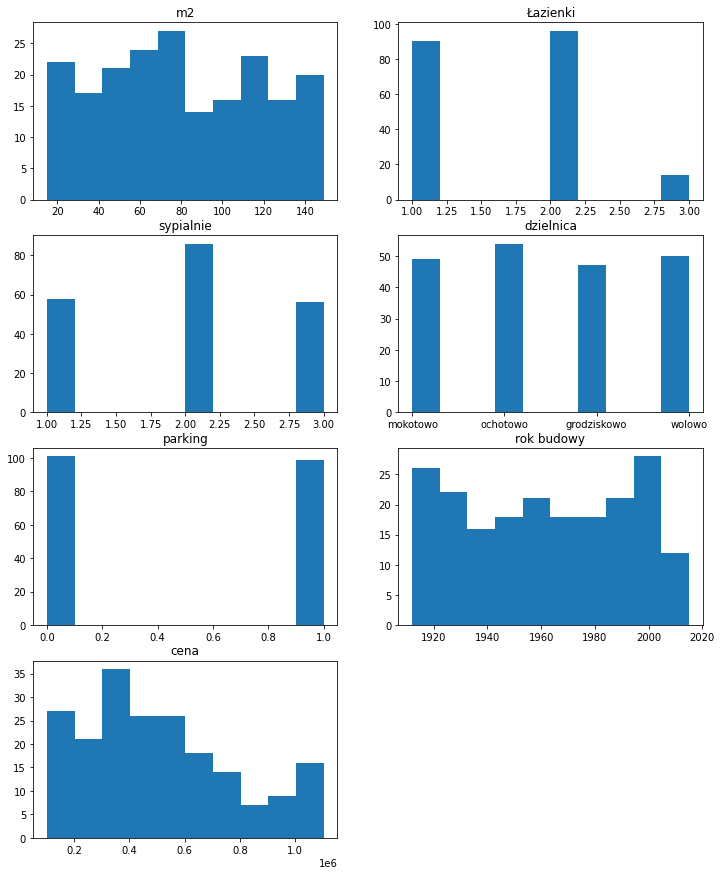

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 15))

plt.subplot(4, 2, 1)
plt.hist(mieszkania['m2'])
plt.title('m2')

plt.subplot(4, 2, 2)
plt.hist(mieszkania['ilość_łazienek'])
plt.title('Łazienki')

plt.subplot(4, 2, 3)
plt.hist(mieszkania['ilość_sypialni'])
plt.title('sypialnie')

plt.subplot(4, 2, 4)
plt.hist(mieszkania['dzielnica'])
plt.title('dzielnica')

plt.subplot(4,2,5)
plt.hist(mieszkania['parking_podziemny'])
plt.title('parking')

plt.subplot(4, 2, 6)
plt.hist(mieszkania['rok_budowy'])
plt.title('rok budowy')

plt.subplot(4, 2, 7)
plt.hist(mieszkania['cena'])
plt.title('cena')


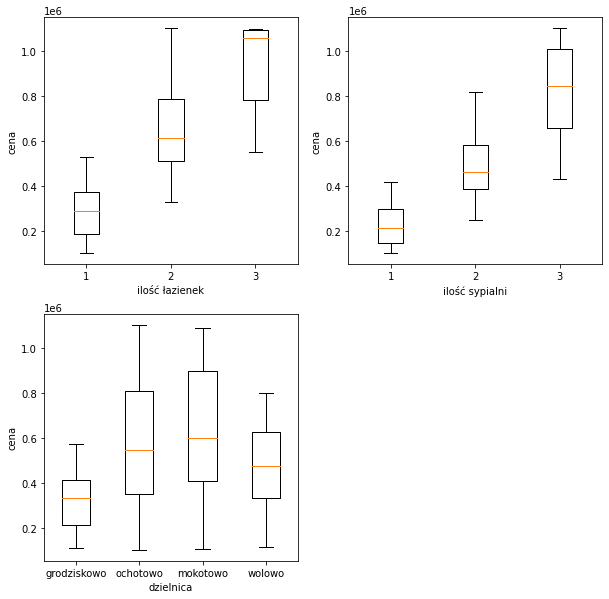

In [6]:
_ = plt.figure(figsize = (10, 10))

plt.subplot(2, 2, 1)
_ = plt.boxplot([mieszkania['cena'].loc[mieszkania['ilość_łazienek'] == 1],
             mieszkania['cena'].loc[mieszkania['ilość_łazienek'] == 2],
             mieszkania['cena'].loc[mieszkania['ilość_łazienek'] == 3]])
plt.xlabel('ilość łazienek')
plt.ylabel('cena')

plt.subplot(2, 2, 2)
_ = plt.boxplot([mieszkania['cena'].loc[mieszkania['ilość_sypialni'] == 1],
             mieszkania['cena'].loc[mieszkania['ilość_sypialni'] == 2],
             mieszkania['cena'].loc[mieszkania['ilość_sypialni'] == 3]])
plt.xlabel('ilość sypialni')
plt.ylabel('cena')

plt.subplot(2, 2, 3)
_ = plt.boxplot([mieszkania['cena'].loc[mieszkania['dzielnica'] == 'grodziskowo'],
             mieszkania['cena'].loc[mieszkania['dzielnica'] == 'ochotowo'],
             mieszkania['cena'].loc[mieszkania['dzielnica'] == 'mokotowo'],
             mieszkania['cena'].loc[mieszkania['dzielnica'] == 'wolowo']])
plt.xlabel('dzielnica')
plt.ylabel('cena')
_ = plt.xticks([1,2,3,4], ['grodziskowo', 'ochotowo', 'mokotowo', 'wolowo'])


Z powyższej analizy wynika, że zmienne ilość łazienek oraz ilość sypialni są bardzo skorelowane z ceną. Być może w celu dokładniejszej walidacji krzyżowej należałoby zadbać, aby w każdym zbiorze walidacyjnym  znalezli się reprezentanci każdej z tych kategorii.

Ogólnie, najmniejszy bias ma Leave-One-Out-Cross-Validation. W przypadku tego zadania byłoby to wykonalne, bo danych jest niedużo (200 obserwacji).